In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from src.renderer import Renderer
from src.data.masked_datamodule import MaskedDataModule
from src.config import get_parser

In [10]:
config = get_parser().parse_args(args=[])
config.viewpoint_distance = 1.0
# Set the cuda device
device = torch.device("cuda:0")

renderer = Renderer(config).to(device)
renderer

Renderer(
  (renderer): ShadingPointsRenderer(
    (rasterizer): PointsRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (compositor): ShadingCompositor(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

In [11]:
blueprint = np.load(os.path.join(config.data_dir, config.blueprint))
w =  config.raster_patch_size
blueprint['points'].shape, blueprint['normals'].shape

((1, 3, 256, 256), (1, 3, 256, 256))

In [12]:
import torch.nn.functional as F 
blueprint = np.load(os.path.join(config.data_dir, config.blueprint))
w =  config.raster_patch_size

def resize(t, w):
    return F.interpolate(t, size=(w, w), mode='bicubic', align_corners=True)

def normalize(t):
    return F.normalize(t, p=2, dim=1)

ws, wd = 0, 128
hs, hd = 0, 128
points = torch.tensor(blueprint['points'][:, :, ws:ws+wd, hs:hs+hd], device=device)
normals = torch.tensor(blueprint['normals'][:, :, ws:ws+wd, hs:hs+hd], device=device)                      


points = resize(points, w)#[0]
normals = normalize(resize(points, w))#[0]
points.shape, normals.shape

(torch.Size([1, 3, 1000, 1000]), torch.Size([1, 3, 1000, 1000]))

In [13]:
points.shape
bs = points.size(0) # (b, 3, w, h)
pt_points = points.reshape(bs, 3, -1).permute(0, 2, 1)
pt_points.shape

torch.Size([1, 1000000, 3])

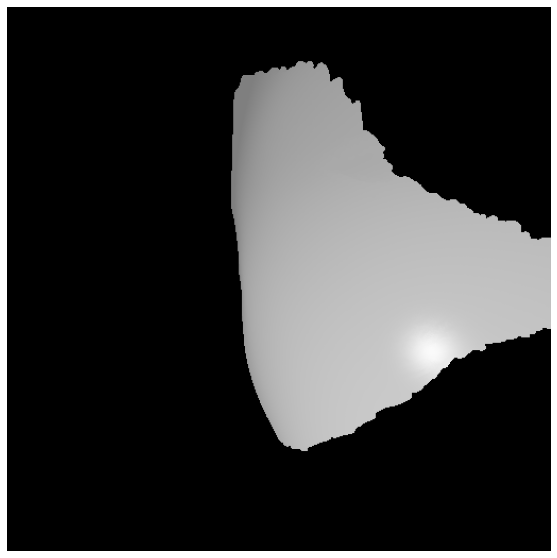

In [14]:
images = renderer(points.to(device), normals.to(device), translate=True)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

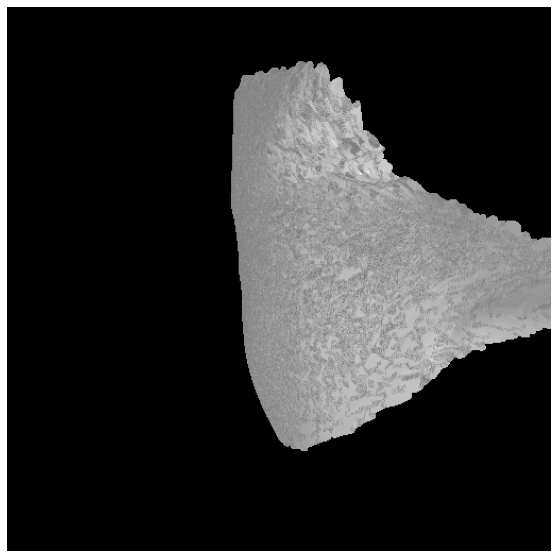

In [15]:
images = renderer(points.to(device), normals=None, translate=True)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");